<a href="https://colab.research.google.com/github/PSKdream/CE59423/blob/main/Project/%5BML%5D_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


#Prepare Data

In [3]:
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
url = 'https://raw.githubusercontent.com/PSKdream/CE59423/main/Project/bananaset.csv'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, 
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

In [ ]:
dataset = raw_dataset.copy()
dataset.tail()

,W,L,o-50
6,131,39.8,11.8
7,130,39.8,11.5
8,161,39.5,12.9
9,149,40.7,12.3
10,141,40.0,12.7


In [ ]:
dataset.isna().sum()

W       0
L       0
o-50    0
dtype: int64

In [ ]:
dataset = dataset.dropna()

In [ ]:
# dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [ ]:
# dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
# dataset.tail()

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

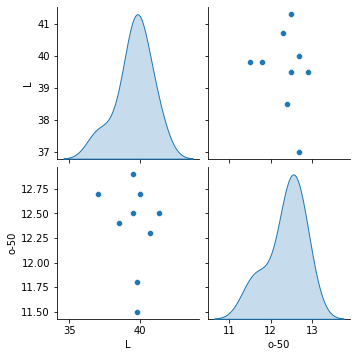

In [ ]:
sns.pairplot(train_dataset[['L', 'o-50']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
W,9.0,141.000000,10.136567,130.0,133.0,141.0,147.0,161.0
L,9.0,39.566667,1.240967,37.0,39.5,39.8,40.0,41.3
o-50,9.0,12.366667,0.450000,11.5,12.3,12.5,12.7,12.9


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('W')
test_labels = test_features.pop('W')

#Train

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [ ]:
print(normalizer.mean.numpy())

[[39.567 12.367]]


In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[38.5 12.4]]

Normalized: [[-0.91  0.08]]


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  # plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

##nn

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 2)                5         
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 8
Trainable params: 3
Non-trainable params: 5
_________________________________________________________________


In [ ]:
# linear_model.predict(train_features[:10])

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 19.5 s, sys: 728 ms, total: 20.3 s
Wall time: 21.4 s


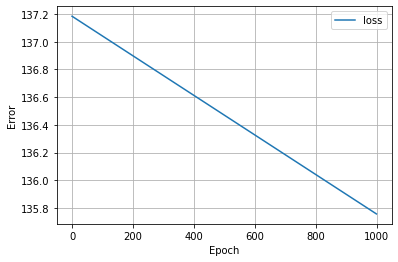

In [ ]:
plot_loss(history)

##DNN

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      # layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 2)                5         
 ion)                                                            
                                                                 
 dense_16 (Dense)            (None, 64)                192       
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=2000)

CPU times: user 36.9 s, sys: 1.49 s, total: 38.4 s
Wall time: 37.6 s


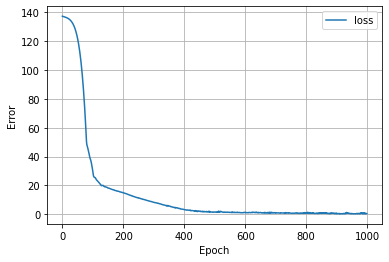

In [ ]:
plot_loss(history)

##analyze

In [ ]:
test_results = {}

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [Weight]']).T

,Mean absolute error [Weight]
linear_model,149.336487
dnn_model,9.749985


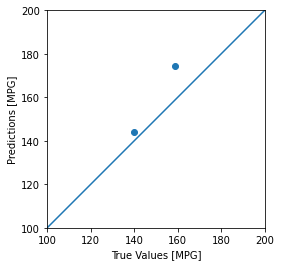

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [100, 200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

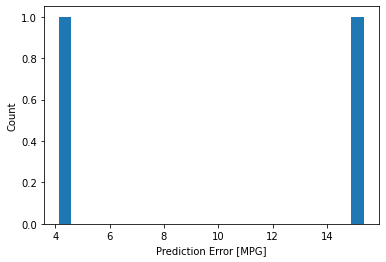

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [ ]:
# dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [ ]:
# reloaded = tf.keras.models.load_model('dnn_model')

# test_results['reloaded'] = reloaded.evaluate(
#     test_features, test_labels, verbose=0)

OSError: ignored